# Exploratory analysis of the ID features

`host_id` and `id` - are they useful at all?

As `id` is presumably monotonically increasing, could it be used to capture time in some way? Does it exhibit some seasonality perhaps? 

For `host_id`, does the reputation/preference of certain hosts mean that their listings are more/less expensive?

In [9]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Load in the data
df = pd.read_csv('../data/AB_NYC_2019.csv')

df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
df_ids = df[['id','host_id','price']]

profile = ProfileReport(df_ids, title='Airbnb exploratory - IDs', explorative=True)

profile.to_widgets()

/usr/local/Caskroom/miniconda/base/envs/airbnb-price-prediction/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/usr/local/Caskroom/miniconda/base/envs/airbnb-price-prediction/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Initial observations
* no missing values
* all the IDs are unique, which indicates there are no duplicates
* 76% of the listings are by different hosts, so lots of variability in this feature
* there are 4 'super hosts' (ie hosts with over 100 listings):
    
    * 219517861 with 327,
    * 107434423 with 232,
    * 30283594 with 121,
    * 137358866 with 103
    
There are no noticeable correlations in the features compared with the price thus far, but the graphs above aren't too informative. Let's plot the variables against `price`

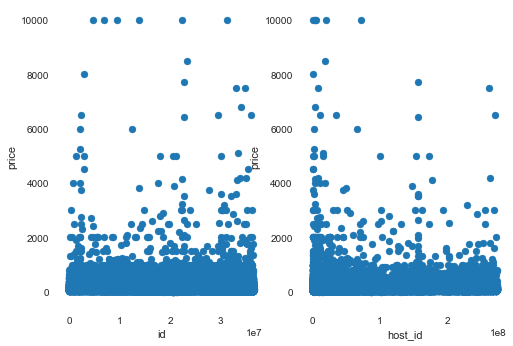

In [20]:
plt.subplot(1,2,1)
plt.scatter(df_ids['id'],df_ids['price'])
plt.xlabel('id')
plt.ylabel('price')

plt.subplot(1,2,2)
plt.scatter(df_ids['host_id'],df_ids['price'])
plt.xlabel('host_id')
plt.ylabel('price')

plt.show()

### Let's look at the `id` feature first

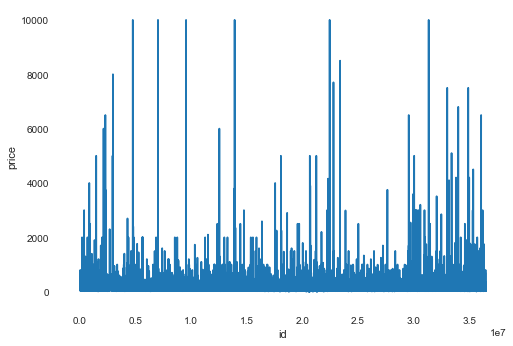

In [15]:
plt.plot(df_ids['id'],df_ids['price'])
plt.xlabel('id')
plt.ylabel('price')
plt.show()

Looks like there _could_ be some seasonality exhibited, hard to say much from this plot. Let's look at an autocorrelation plot to see if there's anything interesting here.

In [ ]:
df_ids.index = df_ids['id']

plot_acf(df_ids['price'], lags=50)
plt.show()

We can see that there is some weak correlation between values with a lag < 10, which is an indicator that listings with similar IDs, and thus listings that were made at a similar time, will be more likely to be listed at a similar price point. IE, there _could_ be some seasonal effect at play here which is causing hosts to generally go for similar price points at similar times. However the predictive power of this is extremely limited as the values that `id` takes increase monotonically, and so captures nothing useful about a general seasonal trend:
    
    if our model had learnt that ids in the range 100-110 were all likely to be listed at a lower price, due to some seasonal effect, we can't then use that information to predict that a listing with `id` 250 would have a lower price even though it's a similar time of year. Now if the problem we were solving was to ONLY predict prices for Airbnb listings in 2019, then the id feature might be very useful.

### host_id

It looks as though from the plot above there could be some skew towards more mature hosts (ie those with lower `host_ids`) having higher listing prices. However the distribution of values is also heavily skewed towards the lower `host_ids` so it may just be due to that. Let's look into this.

Let's bucket the `host_ids` and look at the average price per-bucket. 

/usr/local/Caskroom/miniconda/base/envs/airbnb-price-prediction/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


                 id       host_id         price  host_id_bucketed
count  4.889500e+04  4.889500e+04  48895.000000      48895.000000
mean   1.901714e+07  6.762001e+07    152.720687          4.481992
std    1.098311e+07  7.861097e+07    240.154170          5.689038
min    2.539000e+03  2.438000e+03      0.000000          0.000000
25%    9.471945e+06  7.822033e+06     69.000000          0.000000
50%    1.967728e+07  3.079382e+07    106.000000          2.000000
75%    2.915218e+07  1.074344e+08    175.000000          7.000000
max    3.648724e+07  2.743213e+08  10000.000000         19.000000


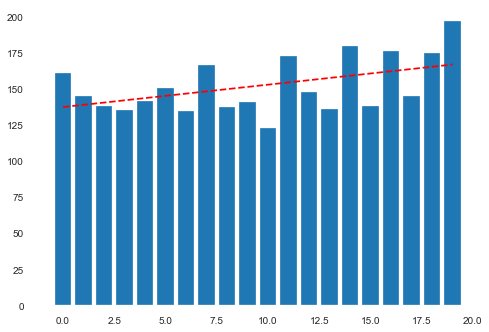

In [61]:
df_ids['host_id_bucketed'] = pd.cut(df_ids['host_id'],20, labels=False)
print(df_ids.describe())

avg_price = df_ids.groupby('host_id_bucketed')['price'].mean()

plt.bar(avg_price.index,avg_price.values)

# Plot trendline
z = np.polyfit(avg_price.index,avg_price.values, 1)
p = np.poly1d(z)
plt.plot(avg_price.index,p(avg_price.index),"r--")

plt.show()

There actually appears to be a weak positive trend between the `host_id` and `price`, indicating that newer hosts tend to list for higher prices? We of course have to be mindful again of the fact that there are many fewer samples for the greater `host_id` values. Let's look into it a bit.

In [62]:
print(df_ids['host_id_bucketed'].value_counts())

0     16479
1      6889
2      4062
3      3405
4      1914
5      1600
16     1536
7      1478
11     1180
19     1166
6      1164
9      1122
10     1046
8      1010
18      925
14      892
15      851
17      765
13      745
12      666
Name: host_id_bucketed, dtype: int64


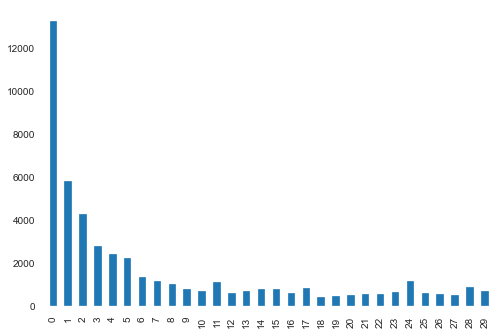

In [60]:
df_ids['host_id_bucketed'].value_counts(sort=False).plot.bar()

We can see that there's certainly a large skew towards the lower buckets, however our more extreme buckets still have a significant number of samples in them, enough to indicate that this could be a real trend.